In [92]:
import os
import sys
import glob as glob
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import desispec.io
import fitsio
%matplotlib inline
sb.set_style('white')

# In this notebook we will simulate Lyman alpha quasar spectra using the DESI code quickqusars

## First let us define some useful functions for visualization 

In [148]:
#A simple filter was added to retain some of the noise and check this is reproduced,
#but still be able to spot differences due to features by eye. 
#Plotspec routine was taken https://github.com/desihub/tutorials/blob/master/Intro_to_DESI_spectra.ipynb. 
#It allows to add the true spectra although we will not use this option here 
#These plots will show the three arms of the spectrograph in colors blue ['b'], red ['r'] and yellow ['z'].


def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=1,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
        
    plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return
    
#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    if label!=None:
        plt.legend(loc='best')
    

# Let's see what are the parameters needed to run a quickquasars simulation

In [3]:
!quickquasars --help

usage: quickquasars [-h] -i [INFILE [INFILE ...]] [-o OUTFILE]
                    [--outdir OUTDIR] [--program PROGRAM] [--seeing SEEING]
                    [--airmass AIRMASS] [--exptime EXPTIME]
                    [--moonfrac MOONFRAC] [--moonalt MOONALT]
                    [--moonsep MOONSEP] [--seed SEED] [--skyerr SKYERR]
                    [--downsampling DOWNSAMPLING] [--zmin ZMIN] [--zmax ZMAX]
                    [--wmin WMIN] [--wmax WMAX] [--dwave DWAVE]
                    [--dwave_desi DWAVE_DESI] [--zbest]
                    [--sigma_kms_fog SIGMA_KMS_FOG]
                    [--gamma_kms_zfit [GAMMA_KMS_ZFIT]]
                    [--shift_kms_los SHIFT_KMS_LOS] [--target-selection]
                    [--mags] [--bbflux] [--add-LYB]
                    [--metals [METALS [METALS ...]]]
                    [--metals-from-file [METALS_FROM_FILE]] [--dla DLA]
                    [--balprob BALPROB] [--no-simqso] [--desi-footprint]
                    [--eboss] [--extin

### We will start by running quickquasars in a single pixel, for this we define some of the required parameters. We will run it using different exposures (1,2,3,4) and have one with a very large exposure time for comparison. Also this first runs will not have any contaminant, they only have continum LYA and LYB absorption.

In [182]:
zmin = 1.8 # We use to add it, although it is already set as minimum in the transmission files.
nmax = 10 # maximun number of spectra to simulate in a given pixel, chosen as a small number for speedness in this tutorial.
seed=123 #this ensure reproducibility
exposures = ['1','2','3','4','1e5']
contaminant='0.0-' # Following somehow the convention in https://desi.lbl.gov/trac/wiki/LymanAlphaWG/LondonMocks/v9_quickquasars

In [183]:
path_mocks = '/global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0' # path to london mocks v9.0
ifile=path_mocks + '/v9.0.0/0/0/transmission-16-0.fits.gz'   #Choose one pixel to simulate the quasars. 
outdir=os.path.join(os.environ['SCRATCH'], 'mocks','quickquasar','1pix_test/')  #Where do you want to save the files.
print(outdir) #Adjuts the path if this is not where you want to store the files produced by this tutorial 

/global/cscratch1/sd/alxogm/mocks/quickquasar/1pix_test/


In [184]:
os.makedirs(outdir, exist_ok=True)

In [190]:
#Run quickquasars for the different exposures, store each run a different directory to avoid overwrting.
for exp in exposures:
    if not os.path.exists(outdir +contaminant+exp):
        os.mkdir(outdir +contaminant+exp )
    specfile = outdir +contaminant+exp+'/spectra.fits'
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed}'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:292:simulate_one_healpix: skip existing /global/cscratch1/sd/alxogm/mocks/quickquasar/1pix_test/0.0-1/spectra.fits and /global/cscratch1/sd/alxogm/mocks/quickquasar/1pix_test/0.0-1/zbest-16-0.fits

real	0m3.199s
user	0m2.193s
sys	0m0.932s
INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:q

### Now lets comapare the spectra we got 

from each simulation 

In [87]:
dump = glob.glob(outdir+'*')
path_highexp = dump[0]
del(dump[0])
dump.sort()
print(path_highexp)

/global/cscratch1/sd/alxogm/mocks/quickquasar/0.0-1e5


In [88]:
spectra_highexp = desispec.io.read_spectra(path_highexp+'/spectra.fits')

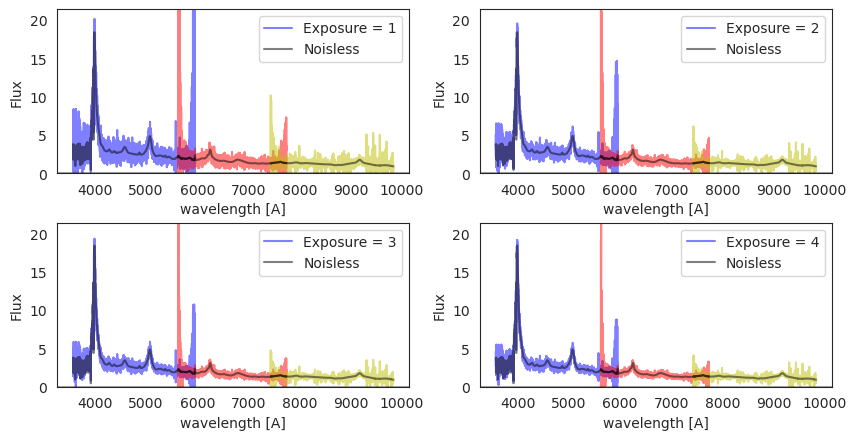

In [90]:
index = 3
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/0.0-')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/spectra.fits')
    plotspec(spectra,index,label='Exposure = '+exposure)
    plotspec(spectra_highexp,index,color=['k','k','k'],label='Noisless')
    #plt.xlim(3500,6500)
plt.subplots_adjust(hspace=0.3,wspace=.2)

### We can compare the differences as well

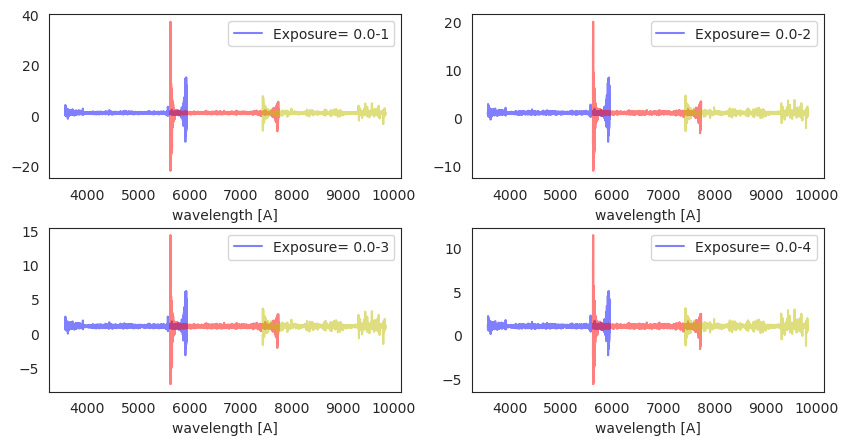

In [91]:
index = 3
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/spectra.fits')
    plotspec_ratio(spectra,spectra_highexp,index,label='Exposure= '+exposure)
    #plt.xlim(3500,4300)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## Lets look at the the other files that were produced: zbest.fits and truth.fits files

#### The "zbest" files are fake redshift catalogs for the simulated spectra. By default it is conformed with the true redshift but we can make it more realistic by adding some errors with the following flags:


--sigma_kms_fog

--gamma_kms_zfit

--shift_kms_los


In [95]:
data_zbest = fitsio.FITS(path_highexp+'/zbest-16-0.fits')

In [96]:
data_zbest


  file: /global/cscratch1/sd/alxogm/mocks/quickquasar/0.0-1e5/zbest-16-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      ZBEST
  2      BINARY_TBL      FIBERMAP

#### The "Truth" files stores all the information regarding the templates used to construct the spectra, as well as the magnitude of the objects, true redshift, if the spectra has contaminats, etc.

In [105]:
data_truth = fitsio.FITS(path_highexp+'/truth-16-0.fits')

In [106]:
data_truth['TRUTH']


  file: /global/cscratch1/sd/alxogm/mocks/quickquasar/0.0-1e5/truth-16-0.fits
  extension: 1
  type: BINARY_TBL
  extname: TRUTH
  rows: 10
  column info:
    TARGETID            i8  
    OBJTYPE            S10  
    SUBTYPE            S10  
    TEMPLATEID          i2  
    SEED                i8  
    Z                   f4  
    MAG                 f4  
    MAGFILTER          S15  
    FLUX_G              f4  
    FLUX_R              f4  
    FLUX_Z              f4  
    FLUX_W1             f4  
    FLUX_W2             f4  
    TRUEZ               f4  
    Z_INPUT             f8  
    DZ_FOG              f8  
    DZ_SYS              f8  
    Z_NORSD             f4  

## So far the spectra has no contaminants, so lets add some. We will start with DLA's 

#### There is two ways to add DLA's, one is at random redshifts and column density, and the other is by what is already stored in the transmission file. In this tutorial we will use the DLAs specified in the transmission file

In [116]:
exp='4'
contaminant='0.1-'
outdir_dla=outdir +contaminant+exp
os.makedirs(outdir +contaminant+exp,exist_ok=True)
        
specfile = outdir +contaminant + exp +'/spectra.fits'
cmd ='quickquasars  -i {ifile} -o {outfile}  --zmin {zmin} --exptime {exptime}\
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed} --dla file'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)

!$cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:162:read_lya_skewers: Read DLAs from transmision file
INFO:quickquasars.py:318:simulate_one_healpix: Add FOG to redshift with sig

In [117]:
path_highexp

'/global/cscratch1/sd/alxogm/mocks/quickquasar/0.0-1e5'

In [135]:
spectra_dla = desispec.io.read_spectra(outdir_dla +'/spectra.fits')
spectra_4exp = desispec.io.read_spectra(outdir + '0.0-4/spectra.fits')

In [129]:
truth_dla = fitsio.FITS(outdir_dla+'/truth-16-0.fits')

In [130]:
truth_dla[3]['TARGETID'][:]

array([115432, 112574, 113645])

In [131]:
mask = np.isin(truth_dla[1]['TARGETID'][:],truth_dla[3]['TARGETID'][:])

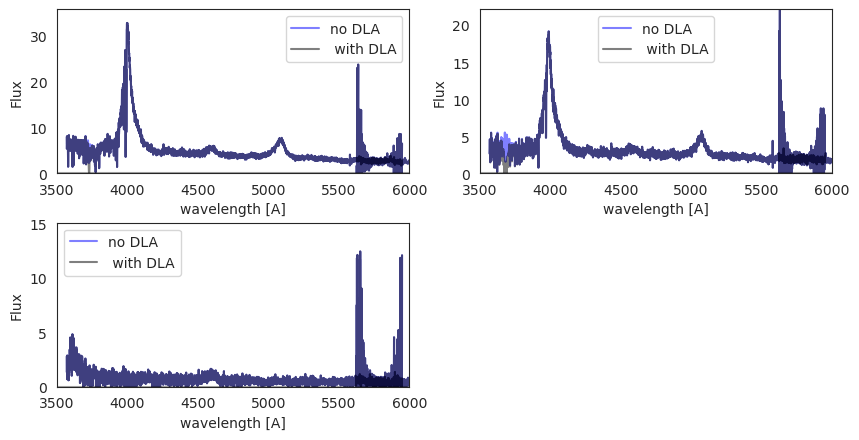

In [140]:
index = np.arange(nmax)
index = index[mask]
plt.figure(figsize=(10,5),dpi=100)
for i in range(3):
    plt.subplot(221+i)
    plotspec(spectra_4exp,index[i],color=['b','b','b'],label='no DLA')
    plotspec(spectra_dla,index[i],color=['k','k','k'],label=' with DLA')
    plt.xlim(3500,6000) #Make a zoom to see the differences
plt.subplots_adjust(hspace=0.3,wspace=.2)

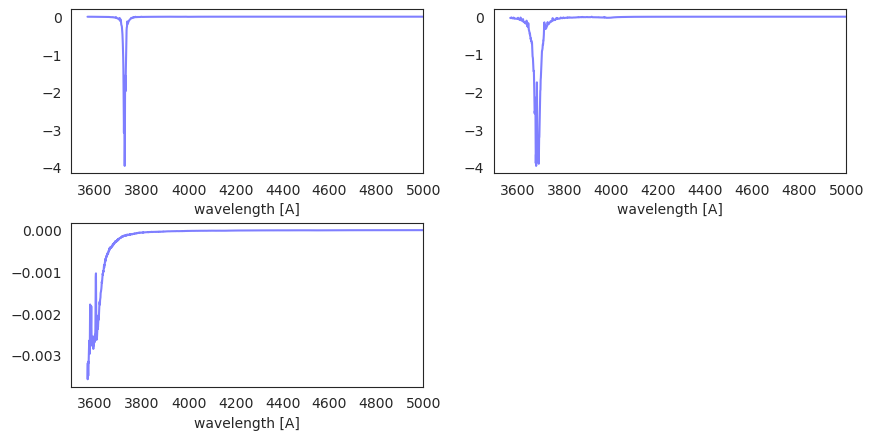

In [150]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(3):
    plt.subplot(221+i)
    plotspec_diff(spectra_dla,spectra_4exp,index[i])
    plt.xlim(3500,5000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## Next, lets add BALs

In [155]:
exp='4'
contaminant='0.1BAL-'
outdir_bal=outdir +contaminant+exp
os.makedirs(outdir_bal,exist_ok=True)

specfile = outdir +contaminant + exp +'/spectra.fits'
cmd ='quickquasars  -i {ifile} -o {outfile}  --zmin {zmin} --exptime {exptime}\
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed} --balprob 0.5'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
!$cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bal_templates_v3.0.fits
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:quickquasars.

In [158]:
truth_bal = fitsio.FITS(outdir_bal+'/truth-16-0.fits')
mask = np.isin(truth_bal[1]['TARGETID'][:],truth_bal[3]['TARGETID'][:])
index = np.arange(nmax)
index = index[mask]

In [159]:
len(index)

7

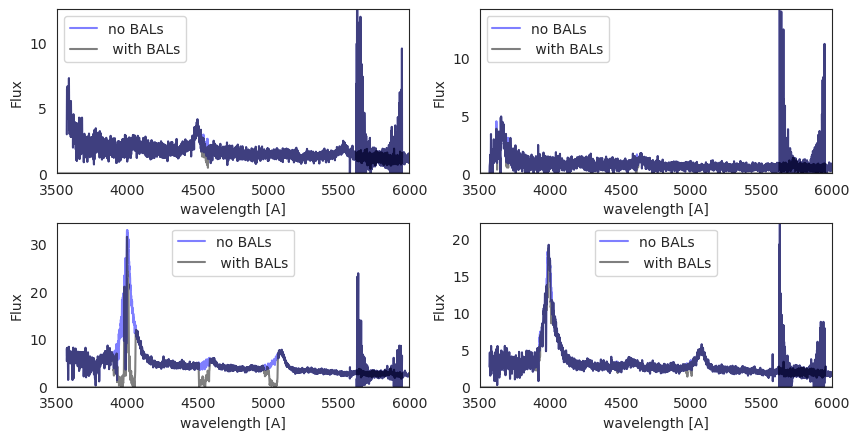

In [162]:
spectra_bal = desispec.io.read_spectra(outdir_bal +'/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_4exp,index[i],color=['b','b','b'],label='no BALs')
    plotspec(spectra_bal,index[i],color=['k','k','k'],label=' with BALs')
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

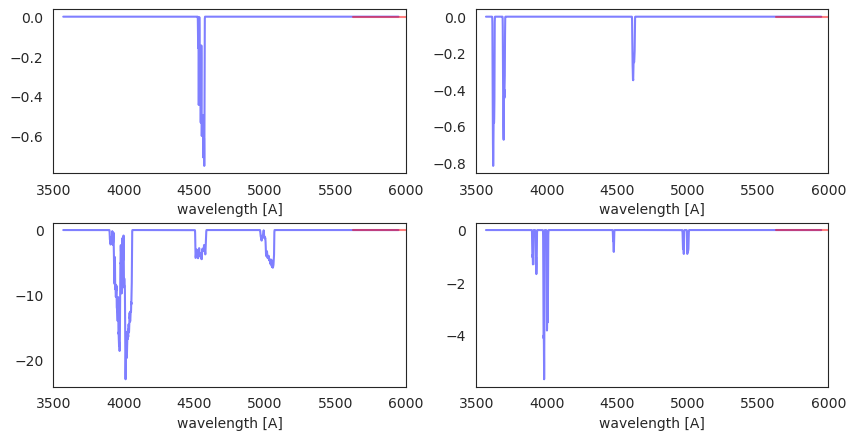

In [163]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_diff(spectra_bal,spectra_4exp,index[i])
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

# Finally, we can also add metals

In [168]:
exp='4'
contaminant='0.1MET-'
outdir_metal=outdir +contaminant+exp
os.makedirs(outdir_metal,exist_ok=True)
specfile = outdir_metal+'/spectra.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
     --nmax {nmax} --seed {seed} --metals-from-file'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
!time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:128:read_lya_skewers: Added F_Metals from transmision file
INFO:quickquasars.py:318:simulate_one_healpix: Add FOG to redshift wit

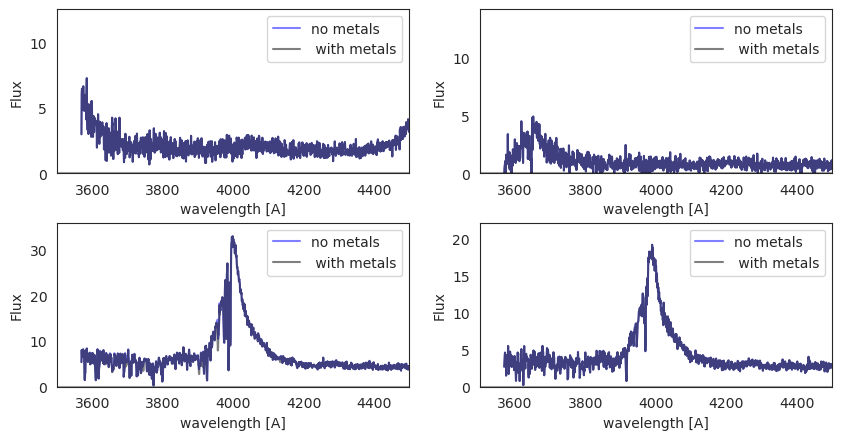

In [175]:
spectra_metals = desispec.io.read_spectra(outdir_metal +'/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_4exp,i,color=['b','b','b'],label='no metals')
    plotspec(spectra_metals,i,color=['k','k','k'],label=' with metals')
    plt.xlim(3500,4500)
plt.subplots_adjust(hspace=0.3,wspace=.2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


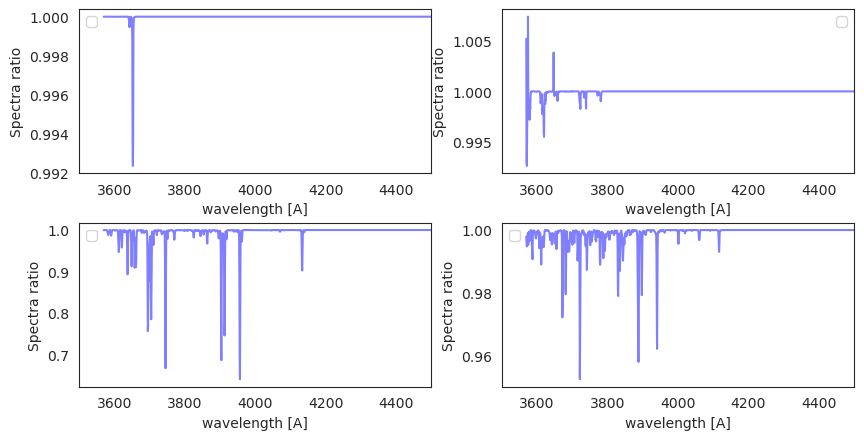

In [176]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_ratio(spectra_metals,spectra_4exp,i)
    plt.ylabel('Spectra ratio')
    plt.xlim(3500,4500)
    #plt.ylim(0.8,1.01)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## As stated at the begining, all this has been for a sinlge pixel but we can also run a quickquasar simulation for the full DESI footprint. For this, lets take a look and run to the script quickquasars.sh

 ## Now that we have a bigger quickquasar run, we can stack the outputs for each pixel into a sinlge catalog

In [197]:
mock_path = os.path.join(os.environ['SCRATCH'], 'mocks','quickquasar')
out_zcat = mock_path+'/tutorial-0.3-4/'

In [198]:
cmd='desi_zcatalog -i {ipath} -o {outfile} --fibermap'.format(ipath=out_zcat+'/spectra-16/',outfile=out_zcat+'/zcat.fits')
!time $cmd

INFO:desi_zcatalog:175:<module>: wrote /global/cscratch1/sd/alxogm/mocks/quickquasar/tutorial-0.3-4//zcat.fits

real	1m30.972s
user	0m9.425s
sys	0m2.539s


In [199]:
zcat = fitsio.FITS(out_zcat+'/zcat.fits')
zcat


  file: /global/cscratch1/sd/alxogm/mocks/quickquasar/tutorial-0.3-4//zcat.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      ZCATALOG

In [200]:
zcat[1]


  file: /global/cscratch1/sd/alxogm/mocks/quickquasar/tutorial-0.3-4//zcat.fits
  extension: 1
  type: BINARY_TBL
  extname: ZCATALOG
  rows: 267810
  column info:
    CHI2                f8  
    COEFF               f8  array[4]
    Z                   f8  
    ZERR                f8  
    ZWARN               i8  
    SPECTYPE           S96  
    SUBTYPE            S16  
    TARGETID            i8  
    DELTACHI2           f8  
    BRICKNAME           S8  
    RA                  f8  
    DEC                 f8  
    FLUX_G              f4  
    FLUX_R              f4  
    FLUX_Z              f4  

# To finish this part of the tutorial create some QA plots

#### We can look at the distriubution of objects in the sky 

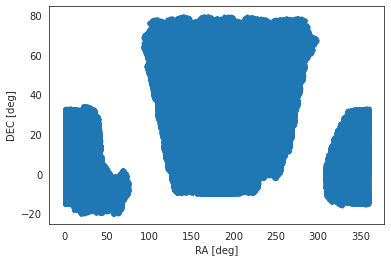

In [201]:
plt.scatter(zcat[1]['RA'][:],zcat[1]['DEC'][:],marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

#### Next we can look at the object distributions for each pixels. For that we define functions to go from angles to pixels and back

In [202]:
import healpy

In [203]:
def get_pix(ra,dec,nside=16):
    phi = ra*np.pi / 180.
    th = np.pi/2. - dec*np.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    return pix

def pix2ang_deg(nside,pix,nest=True):
    pix_rad_dec,pix_rad_ra = healpy.pix2ang(nside,pix,nest=nest)
    pix_ra = pix_rad_ra * 180. / np.pi
    pix_dec = (np.pi/2.-pix_rad_dec)*180./np.pi
    return pix_ra, pix_dec

In [204]:
pix_zcat = get_pix(zcat[1]['RA'][:],zcat[1]['DEC'][:])

In [205]:
ra_zcat,dec_zcat = pix2ang_deg(16,np.unique(pix_zcat),nest=True)

#### Here we are just ploting the pixels, in the previous plot we plotted all the objects

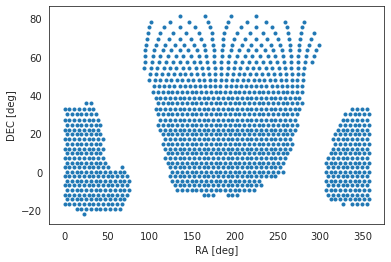

In [206]:
plt.scatter(ra_zcat,dec_zcat,marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

#### Now lets plot the density of objects per pixels as well at the mean redshift in each pixel

In [207]:
def get_density(pix,nside):
    bincounts_pix = np.bincount(pix)
    unique_pix = np.unique(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix
    return density

Text(0, 0.5, 'DEC [deg]')

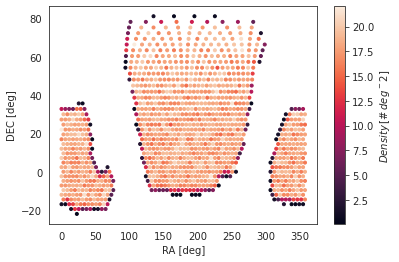

In [208]:
plot1 = plt.scatter(ra_zcat,dec_zcat,c=get_density(pix_zcat,16),marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$Density \, [\# \, deg^-2]$')
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0, 0.5, 'DEC [deg]')

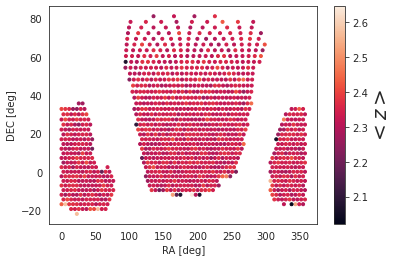

In [209]:
bincounts_pix = np.bincount(pix_zcat)
bincounts_z = np.bincount(pix_zcat,weights=zcat[1]['Z'][:])

z_pix_zcat = bincounts_z[np.unique(pix_zcat)]/bincounts_pix[np.unique(pix_zcat)]

plot1 = plt.scatter(ra_zcat,dec_zcat,c=z_pix_zcat,marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$<z>$',size=20)
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

# What's netxt?

#### We can run picca to calculate the flux over-densities as well as the correletions

#### - Here you can find a tutorial to run picca and do a BAO analysis: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/how_to_run_picca

#### We can also run a DLA finder and BAL finder

#### - DLA finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/DLAfinder
#### - BAL finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/BALfinder